In [1]:
import torch 
import numpy as np
import argparse
import random
import math 
import os  
import torch.nn as nn 
import torch.optim as optim
import torchvision.transforms as transforms

from models import NetD, NetG, NetE 
import datasets

import csv

import matplotlib.pyplot as plt
import pandas as pd


In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Cifar10

In [26]:
dataset = 'cifar10'
fineSize = 128
nThreads = 4
data_root = '../datasets'
batch_size = 6
datasize = None
num_classes = None
train_loader = None
val_loader = None  
assert callable(datasets.__dict__[dataset])
get_dataset = getattr(datasets, dataset)
num_classes = datasets._NUM_CLASSES[dataset]
train_loader, val_loader = get_dataset(
    batch_size=batch_size, num_workers=nThreads, 
    data_root=data_root, fineSize = fineSize)

Building CIFAR-10 data loader with 4 workers


/opt/conda/lib/python3.9/site-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Files already downloaded and verified
CIFAR-10 training data size: 50000
Files already downloaded and verified
CIFAR-10 testing data size: 10000


In [32]:
nc = 3
ngf = 64
nz = 100
fineSize=128
nef = 64 

# load the model trained with adv loss
checkpoint = "cifar10_checkpoint.path.tar"
netG = NetG(nc=nc, ngf=ngf, nz=nz, fineSize=fineSize, nef=nef)
netG = torch.nn.DataParallel(netG).cuda() 
checkpoint = torch.load(checkpoint)
netG.load_state_dict(checkpoint['netG_state_dict']) 

# load the model trained without adv loss
checkpoint = "cifar10_noAdv_checkpoint.path.tar" 
netG_noAdv = NetG(nc=nc, ngf=ngf, nz=nz, fineSize=fineSize, nef=nef)
netG_noAdv = torch.nn.DataParallel(netG_noAdv).cuda() 
checkpoint = torch.load(checkpoint)
netG_noAdv.load_state_dict(checkpoint['netG_state_dict'])

# Generating random pattern
res = 0.06 # the lower it is, the more continuous the output will be. 0.01 is too small and 0.1 is too large
density = 0.25
MAX_SIZE = 10000  
low_pattern = torch.FloatTensor(int(res * MAX_SIZE), int(res * MAX_SIZE)).uniform_(0, 1).mul(255)  
#     print(low_pattern.shape) # [600, 600] 
low_pattern = low_pattern.unsqueeze(0)   # Reshape to have 2 dimensions
#     print(low_pattern.shape)  # [1, 600, 600]
# Resize the low-resolution pattern to the desired size
transform = transforms.Resize((MAX_SIZE, MAX_SIZE), interpolation=transforms.InterpolationMode.BICUBIC)
pattern = transform(low_pattern)
#     print(pattern.shape)  # [1, 10000, 10000] 
pattern = pattern.squeeze(0)
#     print(pattern.shape) # [10000, 10000] 
pattern.div_(255)
pattern = torch.lt(pattern, density).byte()  # 25% 1s and 75% 0s
pattern = pattern.byte()
pattern = pattern.bool()
print('...Random pattern generated')

train_iterator = iter(train_loader)
real_ctx, _ = next(train_iterator)   
true_ctx = real_ctx.clone()
    
# Get random mask
wastedIter = 0
while True:
    x = random.uniform(1, MAX_SIZE - fineSize)
    y = random.uniform(1, MAX_SIZE - fineSize)
    mask = pattern[int(y):int(y + fineSize), int(x):int(x + fineSize)]  # view, no allocation
    area = mask.sum().item() * 100. / (fineSize * fineSize)
    if 20 < area < 30:  # want it to be approximately 75% 0s and 25% 1s
        # print('wasted tries: ', wastedIter)
        break
    wastedIter += 1      
mask_global = mask.repeat(batch_size, 1, 1) # [batch_size, 128, 128]  

real_ctx[:, 0, :, :].masked_fill_(mask_global, 2 * 117.0 / 255.0 - 1.0) 
real_ctx[:, 1, :, :].masked_fill_(mask_global, 2 * 104.0 / 255.0 - 1.0) 
real_ctx[:, 2, :, :].masked_fill_(mask_global, 2 * 123.0 / 255.0 - 1.0)  

# generate image predictions from netG with adv loss
netG.eval()
output = netG(real_ctx)  

# generate image predictions from netG without adv loss
netG_noAdv.eval()
output_noAdv = netG_noAdv(real_ctx);

...Random pattern generated


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

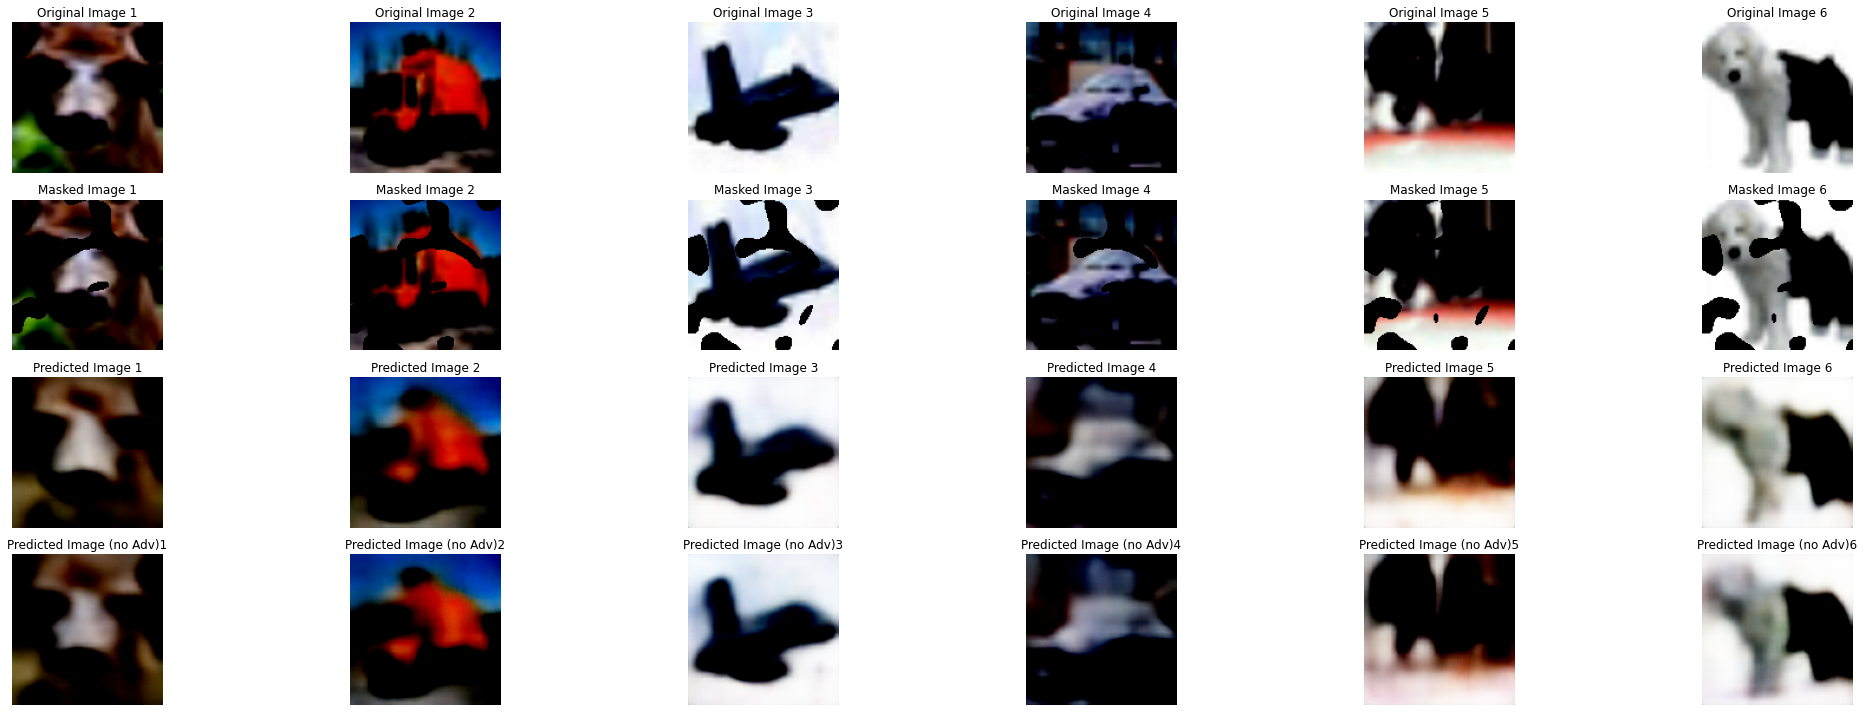

In [33]:
# Convert the tensor to a NumPy array
original_images_np = true_ctx.cpu().detach().numpy()
masked_images_np = real_ctx.cpu().detach().numpy()
predicted_images_np = output.cpu().detach().numpy()
predicted_images_noAdv_np = output_noAdv.cpu().detach().numpy()

original_images_np = np.transpose(original_images_np, (0, 2, 3, 1))
masked_images_np = np.transpose(masked_images_np, (0, 2, 3, 1))
predicted_images_np = np.transpose(predicted_images_np, (0, 2, 3, 1))
predicted_images_noAdv_np = np.transpose(predicted_images_noAdv_np, (0, 2, 3, 1))

# Iterate over the batch and plot each image 
fig, axs = plt.subplots(4, batch_size, figsize=(5 * batch_size, 10))  # Adjust the figure size as needed

# Iterate over the batch and plot each pair of original and predicted images
for i in range(batch_size):
    axs[0, i].imshow(original_images_np[i])
    axs[0, i].axis('off')
    axs[0, i].set_title('Original Image {}'.format(i + 1))
    
    axs[1, i].imshow(masked_images_np[i])
    axs[1, i].axis('off')
    axs[1, i].set_title('Masked Image {}'.format(i + 1))

    axs[2, i].imshow(predicted_images_np[i])
    axs[2, i].axis('off')
    axs[2, i].set_title('Predicted Image {}'.format(i + 1))
    
    axs[3, i].imshow(predicted_images_noAdv_np[i])
    axs[3, i].axis('off')
    axs[3, i].set_title('Predicted Image (no Adv){}'.format(i + 1))

plt.tight_layout()
plt.show()

The experiment compared encoders trained with and without adversarial loss in the context encoder architecture. Surprisingly, there were no noticeable differences in the predicted images or the encoder's performance in subsequent classification tasks. This suggests that the inclusion of adversarial loss did not provide significant benefits for image inpainting or representation learning in this specific experiment on new cifar10.

Index(['Epoch', 'errD', 'errG', 'errG_adv', 'errG_l2'], dtype='object')


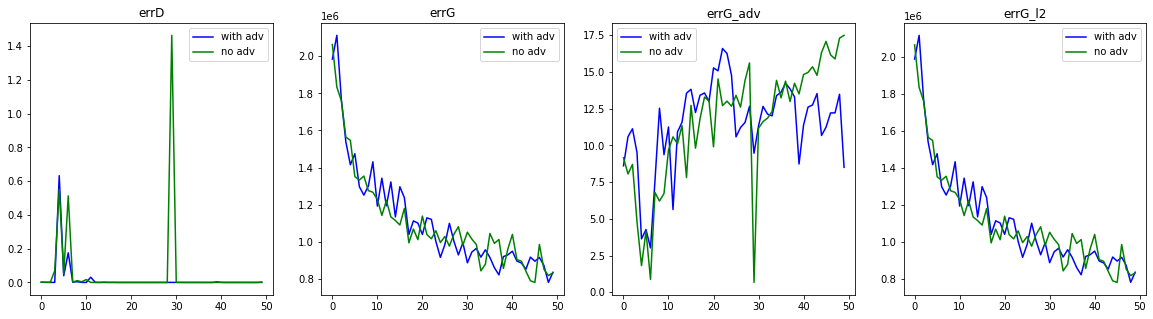

In [29]:
# Plot the losses
csv_file = 'cifar10_loss_data.csv'
df = pd.read_csv(csv_file)
print(df.columns)
epochs = df['Epoch']  

csv_file = 'cifar10_noAdv_loss_data.csv'
df_noAdv = pd.read_csv(csv_file) 

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, col in enumerate(df.columns[1:]):  
    axs[i].plot(epochs, df[col], 'b', label='with adv') 
    axs[i].plot(epochs, df_noAdv[col].iloc[:50], 'g', label='no adv') 
    axs[i].legend()
    axs[i].set_title(col)

# Display the plot
plt.show()

Index(['Epoch', 'k', 'Acc', 'Loss'], dtype='object')


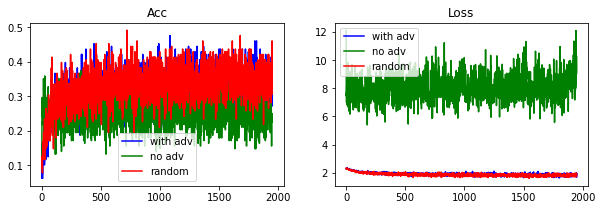

In [23]:
# Figure 4: Plot the classification accuracis (frozen encoders)
csv_file = 'cifar10_classifier_update_data.csv'
df = pd.read_csv(csv_file)
print(df.columns) # Index(['Epoch', 'k', 'Acc', 'Loss'], dtype='object')
epochs = range(len(df['Epoch']))

csv_file = 'cifar10_noAdv_classifier_update_data.csv'
df_noAdv = pd.read_csv(csv_file) 

csv_file = 'cifar10_random_classifier_update_data.csv'
df_random = pd.read_csv(csv_file) 

fig, axs = plt.subplots(1, 2, figsize=(10, 3)) 
for i, col in enumerate(df.columns[2:]):  
    axs[i].plot(epochs, df[col], 'b', label='with adv') 
    axs[i].plot(epochs, df_noAdv[col], 'g', label='no adv') 
    axs[i].plot(epochs, df_random[col], 'r', label='random') 
    axs[i].legend()
    axs[i].set_title(col)

# Display the plot
plt.show()

In [18]:
# Figure 4: Plot the classification accuracis (frozen encoders)
csv_file = 'cifar10_classifier_update_data.csv'
df = pd.read_csv(csv_file)
print(df.columns) # Index(['Epoch', 'k', 'Acc', 'Loss'], dtype='object')
epochs = range(len(df['Epoch']))

csv_file = 'cifar10_noAdv_classifier_update_data.csv'
df_noAdv = pd.read_csv(csv_file) 

csv_file = 'cifar10_random_classifier_update_data.csv'
df_random = pd.read_csv(csv_file) 

print(len(df['Epoch']), len(df_noAdv['Epoch']), len(df_random['Epoch']))
# fig, axs = plt.subplots(1, 2, figsize=(10, 3)) 
# for i, col in enumerate(df.columns[2:]):  
#     axs[i].plot(epochs, df[col], 'b', label='with adv') 
#     axs[i].plot(epochs, df_noAdv[col], 'g', label='no adv') 
#     axs[i].plot(epochs, df_random[col], 'r', label='random') 
#     axs[i].legend()
#     axs[i].set_title(col)

# # Display the plot
# plt.show()

Index(['Epoch', 'k', 'Acc', 'Loss'], dtype='object')
3900 1950 1950


Index(['Epoch', 'k', 'Acc', 'Loss'], dtype='object')


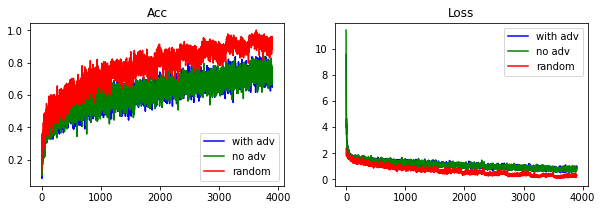

In [49]:
# Figure 6: Plot the classification accuracis (finetuning)
csv_file = 'cifar10_classifier_finetune_update_data.csv'
df = pd.read_csv(csv_file)
print(df.columns) # Index(['Epoch', 'k', 'Acc', 'Loss'], dtype='object')
epochs = range(len(df['Epoch']))

csv_file = 'cifar10_noAdv_classifier_finetune_update_data.csv'
df_noAdv = pd.read_csv(csv_file) 

csv_file = 'cifar10_random_classifier_finetune_update_data.csv'
df_random = pd.read_csv(csv_file) 

fig, axs = plt.subplots(1, 2, figsize=(10, 3)) 
for i, col in enumerate(df.columns[2:]):  
    axs[i].plot(epochs, df[col], 'b', label='with adv') 
    axs[i].plot(epochs, df_noAdv[col], 'g', label='no adv') 
    axs[i].plot(epochs, df_random[col], 'r', label='random') 
    axs[i].legend()
    axs[i].set_title(col)

# Display the plot
plt.show()

In [51]:
print(df['Acc'].iloc[0], df_noAdv['Acc'].iloc[0], df_random['Acc'].iloc[0])

0.09375 0.1484375 0.125


# GTSRB

In [3]:
dataset = 'gtsrb'
fineSize = 128
nThreads = 4
data_root = '../datasets'
batch_size = 6
datasize = None
num_classes = None
train_loader = None
val_loader = None  
assert callable(datasets.__dict__[dataset])
get_dataset = getattr(datasets, dataset)
num_classes = datasets._NUM_CLASSES[dataset]
train_loader, val_loader = get_dataset(
    batch_size=batch_size, num_workers=nThreads, 
    data_root=data_root, fineSize = fineSize)

Building celebA data loader with 4 workers
GTSRB training data size: 39209
GTSRB testing data size: 12630


In [4]:
nc = 3
ngf = 64
nz = 100
fineSize=128
nef = 64 

# load the model trained with adv loss
checkpoint = "gtsrb_checkpoint.path.tar"
netG = NetG(nc=nc, ngf=ngf, nz=nz, fineSize=fineSize, nef=nef)
netG = torch.nn.DataParallel(netG).cuda() 
checkpoint = torch.load(checkpoint)
netG.load_state_dict(checkpoint['netG_state_dict']) 

# load the model trained without adv loss
checkpoint = "gtsrb_noAdv_checkpoint.path.tar" 
netG_noAdv = NetG(nc=nc, ngf=ngf, nz=nz, fineSize=fineSize, nef=nef)
netG_noAdv = torch.nn.DataParallel(netG_noAdv).cuda() 
checkpoint = torch.load(checkpoint)
netG_noAdv.load_state_dict(checkpoint['netG_state_dict'])

# Generating random pattern
res = 0.06 # the lower it is, the more continuous the output will be. 0.01 is too small and 0.1 is too large
density = 0.25
MAX_SIZE = 10000  
low_pattern = torch.FloatTensor(int(res * MAX_SIZE), int(res * MAX_SIZE)).uniform_(0, 1).mul(255)  
#     print(low_pattern.shape) # [600, 600] 
low_pattern = low_pattern.unsqueeze(0)   # Reshape to have 2 dimensions
#     print(low_pattern.shape)  # [1, 600, 600]
# Resize the low-resolution pattern to the desired size
transform = transforms.Resize((MAX_SIZE, MAX_SIZE), interpolation=transforms.InterpolationMode.BICUBIC)
pattern = transform(low_pattern)
#     print(pattern.shape)  # [1, 10000, 10000] 
pattern = pattern.squeeze(0)
#     print(pattern.shape) # [10000, 10000] 
pattern.div_(255)
pattern = torch.lt(pattern, density).byte()  # 25% 1s and 75% 0s
pattern = pattern.byte()
pattern = pattern.bool()
print('...Random pattern generated')

train_iterator = iter(train_loader)
real_ctx, _ = next(train_iterator)   
true_ctx = real_ctx.clone()
    
# Get random mask
wastedIter = 0
while True:
    x = random.uniform(1, MAX_SIZE - fineSize)
    y = random.uniform(1, MAX_SIZE - fineSize)
    mask = pattern[int(y):int(y + fineSize), int(x):int(x + fineSize)]  # view, no allocation
    area = mask.sum().item() * 100. / (fineSize * fineSize)
    if 20 < area < 30:  # want it to be approximately 75% 0s and 25% 1s
        # print('wasted tries: ', wastedIter)
        break
    wastedIter += 1      
mask_global = mask.repeat(batch_size, 1, 1) # [batch_size, 128, 128]  

real_ctx[:, 0, :, :].masked_fill_(mask_global, 2 * 117.0 / 255.0 - 1.0) 
real_ctx[:, 1, :, :].masked_fill_(mask_global, 2 * 104.0 / 255.0 - 1.0) 
real_ctx[:, 2, :, :].masked_fill_(mask_global, 2 * 123.0 / 255.0 - 1.0)  

# generate image predictions from netG with adv loss
netG.eval()
output = netG(real_ctx)  

# generate image predictions from netG without adv loss
netG_noAdv.eval()
output_noAdv = netG_noAdv(real_ctx);

...Random pattern generated


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

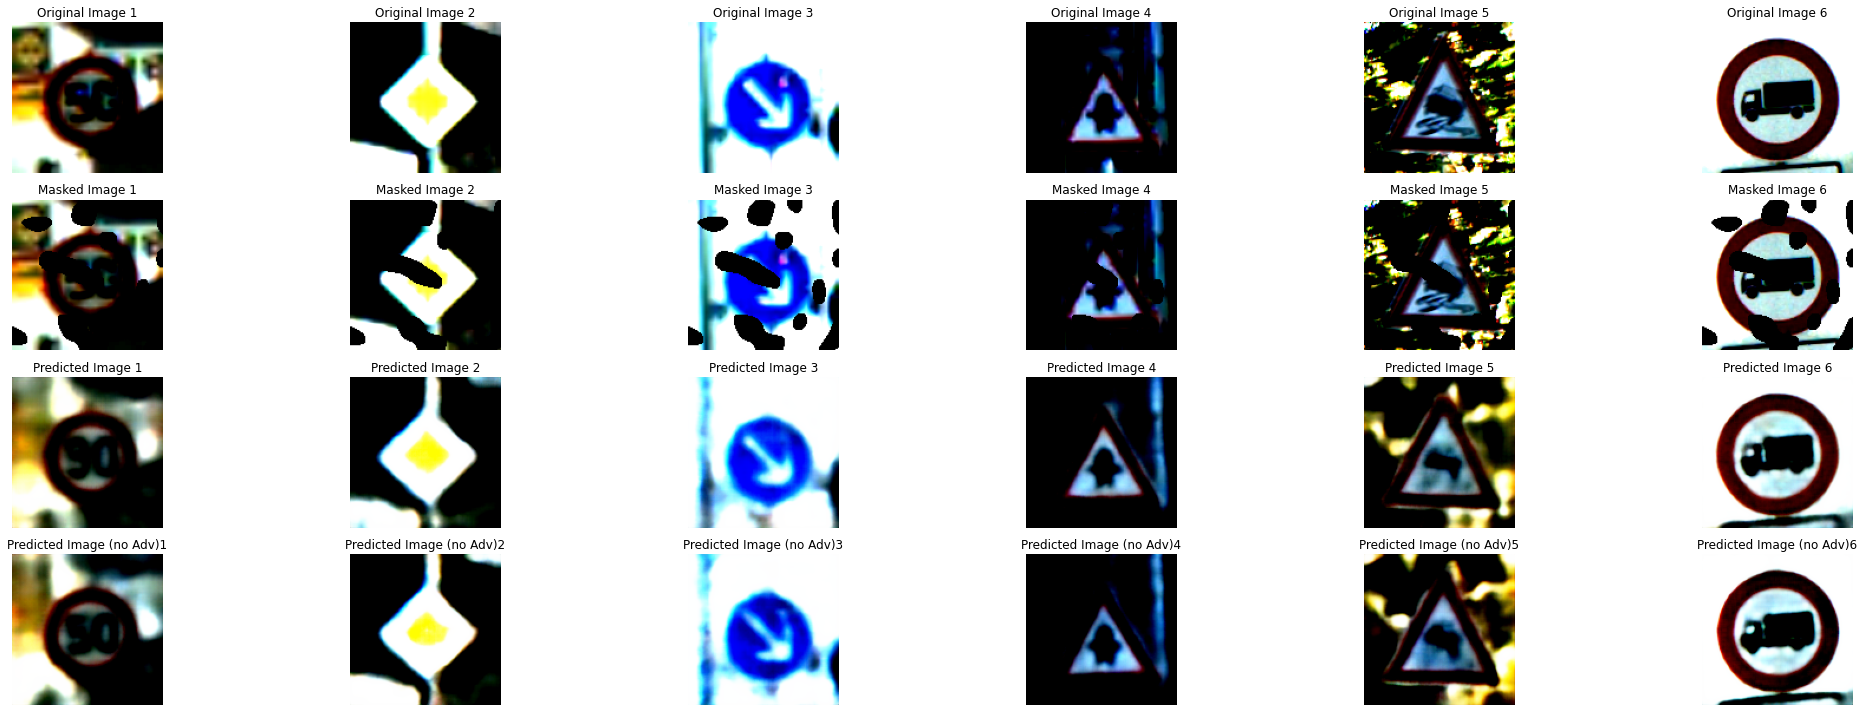

In [46]:
# Convert the tensor to a NumPy array
original_images_np = true_ctx.cpu().detach().numpy()
masked_images_np = real_ctx.cpu().detach().numpy()
predicted_images_np = output.cpu().detach().numpy()
predicted_images_noAdv_np = output_noAdv.cpu().detach().numpy()

original_images_np = np.transpose(original_images_np, (0, 2, 3, 1))
masked_images_np = np.transpose(masked_images_np, (0, 2, 3, 1))
predicted_images_np = np.transpose(predicted_images_np, (0, 2, 3, 1))
predicted_images_noAdv_np = np.transpose(predicted_images_noAdv_np, (0, 2, 3, 1))

# Iterate over the batch and plot each image 
fig, axs = plt.subplots(4, batch_size, figsize=(5 * batch_size, 10))  # Adjust the figure size as needed

# Iterate over the batch and plot each pair of original and predicted images
for i in range(batch_size):
    axs[0, i].imshow(original_images_np[i])
    axs[0, i].axis('off')
    axs[0, i].set_title('Original Image {}'.format(i + 1))
    
    axs[1, i].imshow(masked_images_np[i])
    axs[1, i].axis('off')
    axs[1, i].set_title('Masked Image {}'.format(i + 1))

    axs[2, i].imshow(predicted_images_np[i])
    axs[2, i].axis('off')
    axs[2, i].set_title('Predicted Image {}'.format(i + 1))
    
    axs[3, i].imshow(predicted_images_noAdv_np[i])
    axs[3, i].axis('off')
    axs[3, i].set_title('Predicted Image (no Adv){}'.format(i + 1)) 

plt.tight_layout()
plt.show()

Index(['Epoch', 'errD', 'errG', 'errG_adv', 'errG_l2'], dtype='object')


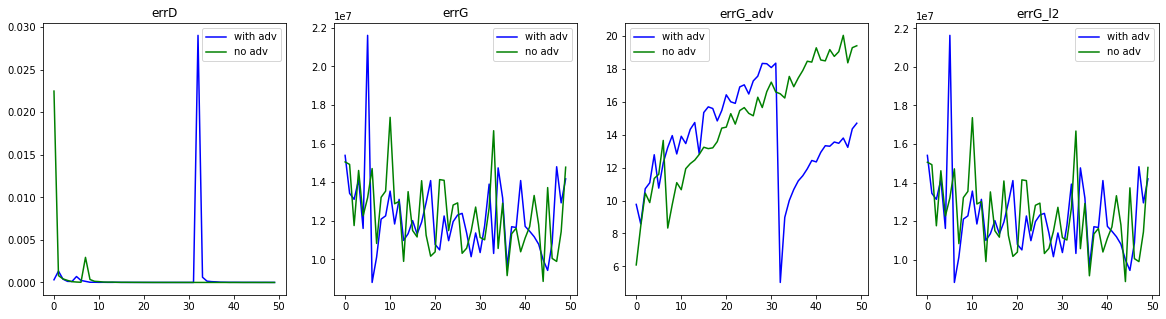

In [8]:
#Plot the losses
csv_file = 'gtsrb_loss_data.csv'
df = pd.read_csv(csv_file)
print(df.columns)
epochs = df['Epoch']  

csv_file = 'gtsrb_noAdv_loss_data.csv'
df_noAdv = pd.read_csv(csv_file) 

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, col in enumerate(df.columns[1:]):  
    axs[i].plot(epochs, df[col], 'b', label='with adv') 
    axs[i].plot(epochs, df_noAdv[col], 'g', label='no adv') 
    axs[i].legend()
    axs[i].set_title(col)

# Display the plot
plt.show()

Index(['Epoch', 'k', 'Acc', 'Loss'], dtype='object')


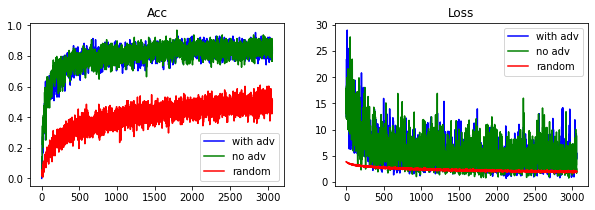

In [17]:
# Figure 7: Plot the classification accuracies
csv_file = 'gtsrb_classifier_update_data.csv'
df = pd.read_csv(csv_file)
print(df.columns) # Index(['Epoch', 'k', 'Acc', 'Loss'], dtype='object')
epochs = range(len(df['Epoch']))

csv_file = 'gtsrb_noAdv_classifier_update_data.csv'
df_noAdv = pd.read_csv(csv_file) 

csv_file = 'gtsrb_random_classifier_update_data.csv'
df_random = pd.read_csv(csv_file) 

fig, axs = plt.subplots(1, 2, figsize=(10, 3)) 
for i, col in enumerate(df.columns[2:]):  
    axs[i].plot(epochs, df[col], 'b', label='with adv') 
    axs[i].plot(epochs, df_noAdv[col], 'g', label='no adv') 
    axs[i].plot(epochs, df_random[col], 'r', label='random') 
    axs[i].legend()
    axs[i].set_title(col)

# Display the plot
plt.show()

# Figure 3, 5, 7

In [4]:
dataset = 'celeba'
fineSize = 128
nThreads = 4
data_root = '../datasets'
batch_size = 6
datasize = None
num_classes = None
train_loader = None
val_loader = None  
assert callable(datasets.__dict__[dataset])
get_dataset = getattr(datasets, dataset)
num_classes = datasets._NUM_CLASSES[dataset]
train_loader, val_loader = get_dataset(
    batch_size=batch_size, num_workers=nThreads, 
    data_root=data_root, fineSize = fineSize)

Building celebA data loader with 4 workers
CelebA training data size: 90000
CelebA testing data size: 10000


In [6]:
nc = 3
ngf = 64
nz = 100
fineSize=128
nef = 64 

# load the model trained with adv loss
checkpoint = "celeba_checkpoint.path.tar"
netG = NetG(nc=nc, ngf=ngf, nz=nz, fineSize=fineSize, nef=nef)
netG = torch.nn.DataParallel(netG).cuda() 
checkpoint = torch.load(checkpoint)
netG.load_state_dict(checkpoint['netG_state_dict']) 

# load the model trained without adv loss
checkpoint = "celeba_noAdv_checkpoint.path.tar" 
netG_noAdv = NetG(nc=nc, ngf=ngf, nz=nz, fineSize=fineSize, nef=nef)
netG_noAdv = torch.nn.DataParallel(netG_noAdv).cuda() 
checkpoint = torch.load(checkpoint)
netG_noAdv.load_state_dict(checkpoint['netG_state_dict'])

# Generating random pattern
res = 0.06 # the lower it is, the more continuous the output will be. 0.01 is too small and 0.1 is too large
density = 0.25
MAX_SIZE = 10000  
low_pattern = torch.FloatTensor(int(res * MAX_SIZE), int(res * MAX_SIZE)).uniform_(0, 1).mul(255)  
#     print(low_pattern.shape) # [600, 600] 
low_pattern = low_pattern.unsqueeze(0)   # Reshape to have 2 dimensions
#     print(low_pattern.shape)  # [1, 600, 600]
# Resize the low-resolution pattern to the desired size
transform = transforms.Resize((MAX_SIZE, MAX_SIZE), interpolation=transforms.InterpolationMode.BICUBIC)
pattern = transform(low_pattern)
#     print(pattern.shape)  # [1, 10000, 10000] 
pattern = pattern.squeeze(0)
#     print(pattern.shape) # [10000, 10000] 
pattern.div_(255)
pattern = torch.lt(pattern, density).byte()  # 25% 1s and 75% 0s
pattern = pattern.byte()
pattern = pattern.bool()
print('...Random pattern generated')

train_iterator = iter(train_loader)
real_ctx, _ = next(train_iterator)   
true_ctx = real_ctx.clone()
    
# Get random mask
wastedIter = 0
while True:
    x = random.uniform(1, MAX_SIZE - fineSize)
    y = random.uniform(1, MAX_SIZE - fineSize)
    mask = pattern[int(y):int(y + fineSize), int(x):int(x + fineSize)]  # view, no allocation
    area = mask.sum().item() * 100. / (fineSize * fineSize)
    if 20 < area < 30:  # want it to be approximately 75% 0s and 25% 1s
        # print('wasted tries: ', wastedIter)
        break
    wastedIter += 1      
mask_global = mask.repeat(batch_size, 1, 1) # [batch_size, 128, 128]  

real_ctx[:, 0, :, :].masked_fill_(mask_global, 2 * 117.0 / 255.0 - 1.0) 
real_ctx[:, 1, :, :].masked_fill_(mask_global, 2 * 104.0 / 255.0 - 1.0) 
real_ctx[:, 2, :, :].masked_fill_(mask_global, 2 * 123.0 / 255.0 - 1.0)  

# generate image predictions from netG with adv loss
netG.eval()
output = netG(real_ctx)  

# generate image predictions from netG without adv loss
netG_noAdv.eval()
output_noAdv = netG_noAdv(real_ctx);

...Random pattern generated


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

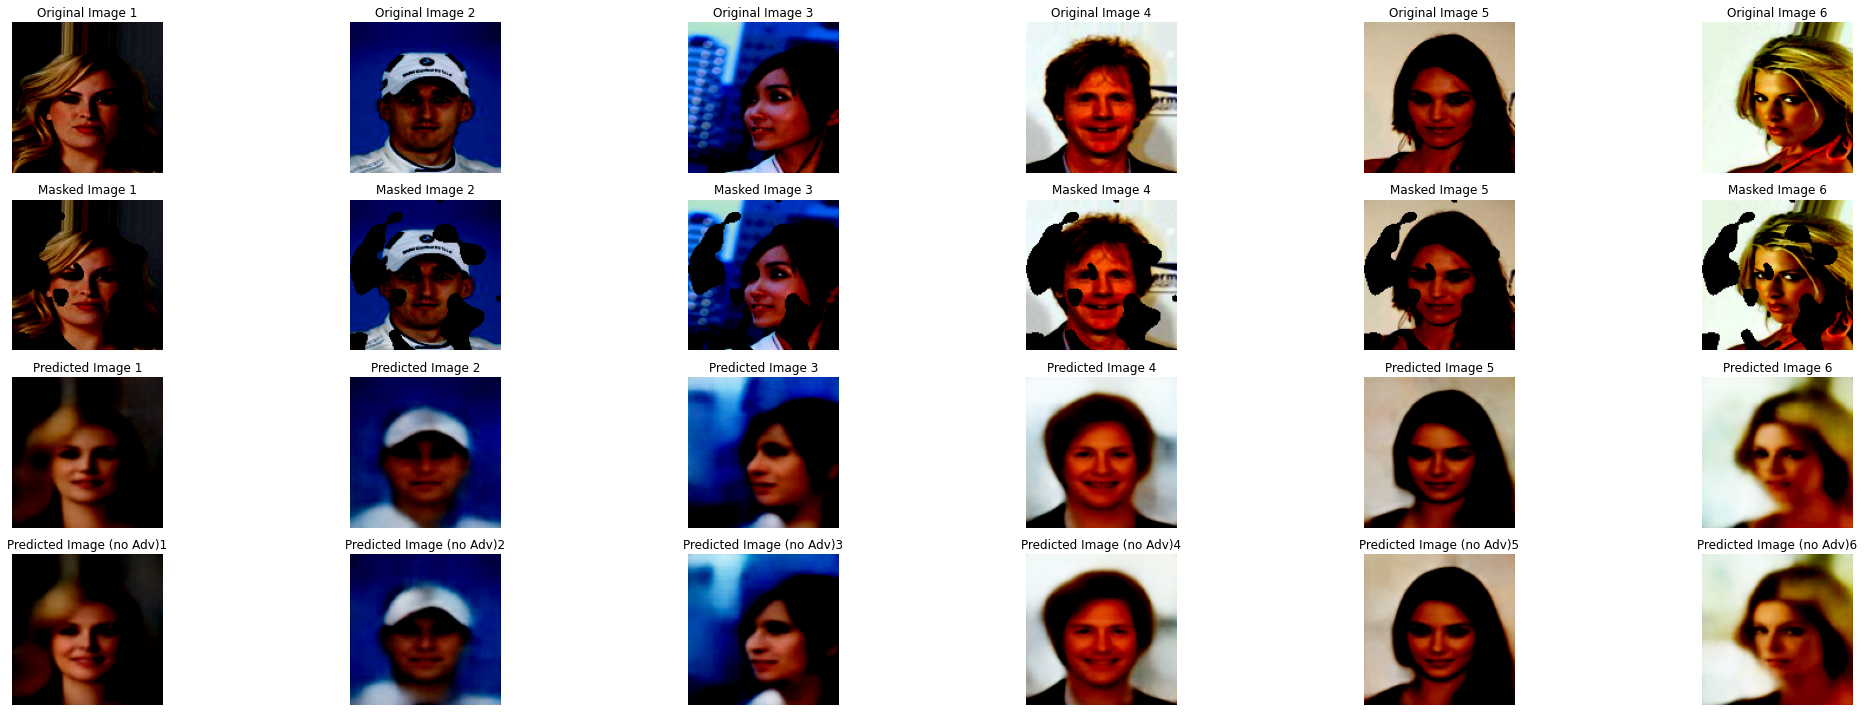

In [7]:
# Convert the tensor to a NumPy array
original_images_np = true_ctx.cpu().detach().numpy()
masked_images_np = real_ctx.cpu().detach().numpy()
predicted_images_np = output.cpu().detach().numpy()
predicted_images_noAdv_np = output_noAdv.cpu().detach().numpy()

original_images_np = np.transpose(original_images_np, (0, 2, 3, 1))
masked_images_np = np.transpose(masked_images_np, (0, 2, 3, 1))
predicted_images_np = np.transpose(predicted_images_np, (0, 2, 3, 1))
predicted_images_noAdv_np = np.transpose(predicted_images_noAdv_np, (0, 2, 3, 1))

# Iterate over the batch and plot each image 
fig, axs = plt.subplots(4, batch_size, figsize=(5 * batch_size, 10))  # Adjust the figure size as needed

# Iterate over the batch and plot each pair of original and predicted images
for i in range(batch_size):
    axs[0, i].imshow(original_images_np[i])
    axs[0, i].axis('off')
    axs[0, i].set_title('Original Image {}'.format(i + 1))
    
    axs[1, i].imshow(masked_images_np[i])
    axs[1, i].axis('off')
    axs[1, i].set_title('Masked Image {}'.format(i + 1))

    axs[2, i].imshow(predicted_images_np[i])
    axs[2, i].axis('off')
    axs[2, i].set_title('Predicted Image {}'.format(i + 1))
    
    axs[3, i].imshow(predicted_images_noAdv_np[i])
    axs[3, i].axis('off')
    axs[3, i].set_title('Predicted Image (no Adv){}'.format(i + 1))

plt.tight_layout()
plt.show()

Index(['Epoch', 'errD', 'errG', 'errG_adv', 'errG_l2'], dtype='object')


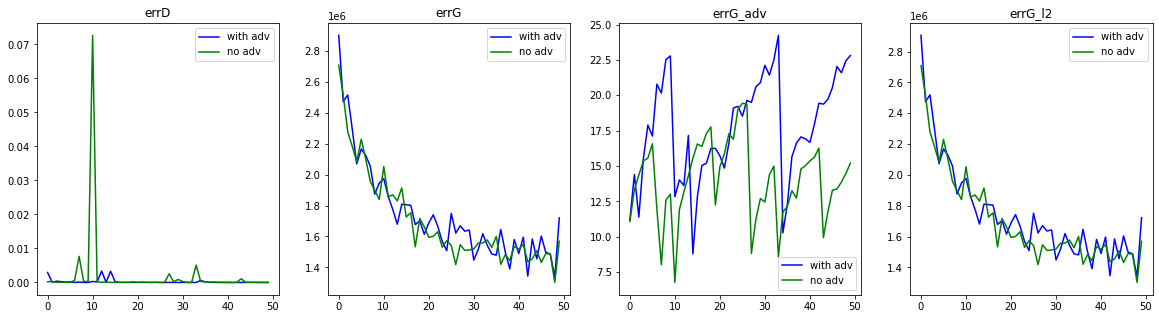

In [21]:
# Figure 5: Plot the losses
csv_file = 'celeba_loss_data.csv'
df = pd.read_csv(csv_file)
print(df.columns)
epochs = df['Epoch']  

csv_file = 'celeba_noAdv_loss_data.csv'
df_noAdv = pd.read_csv(csv_file) 

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, col in enumerate(df.columns[1:]):  
    axs[i].plot(epochs, df[col], 'b', label='with adv') 
    axs[i].plot(epochs, df_noAdv[col], 'g', label='no adv') 
    axs[i].legend()
    axs[i].set_title(col)

# Display the plot
plt.show()

In [22]:
# Figure 7: Plot the classification accuracies
csv_file = 'celeba_classifier_update_data.csv'
df = pd.read_csv(csv_file)
print(df.columns) # Index(['Epoch', 'k', 'Acc', 'Loss'], dtype='object')
epochs = range(len(df['Epoch']))

csv_file = 'celeba_noAdv_classifier_finetune_update_data.csv'
df_noAdv = pd.read_csv(csv_file) 

csv_file = 'celeba_random_classifier_finetune_update_data.csv'
df_random = pd.read_csv(csv_file) 

fig, axs = plt.subplots(1, 2, figsize=(10, 3)) 
for i, col in enumerate(df.columns[2:]):  
    axs[i].plot(epochs, df[col], 'b', label='with adv') 
    axs[i].plot(epochs, df_noAdv[col], 'g', label='no adv') 
    axs[i].plot(epochs, df_random[col], 'r', label='random') 
    axs[i].legend()
    axs[i].set_title(col)

# Display the plot
plt.show()

Index(['Epoch', 'k', 'Acc', 'Loss'], dtype='object')


Index(['Epoch', 'k', 'Acc', 'Loss'], dtype='object')
7030
7030
7030


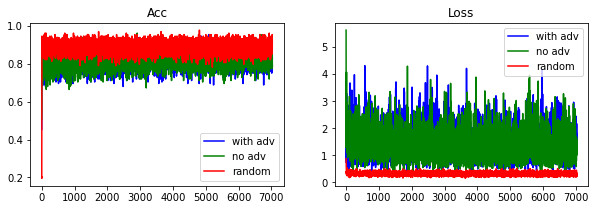

In [12]:
# Figure 5: Plot the classification accuracis (frozen encoders)
csv_file = 'celeba_classifier_update_data.csv'
df = pd.read_csv(csv_file)
print(df.columns) # Index(['Epoch', 'k', 'Acc', 'Loss'], dtype='object')
epochs = range(len(df['Epoch']))
print(len(df['Epoch']))

csv_file = 'celeba_noAdv_classifier_update_data.csv'
df_noAdv = pd.read_csv(csv_file) 
print(len(df_noAdv['Epoch']))

csv_file = 'celeba_random_classifier_update_data.csv'
df_random = pd.read_csv(csv_file) 
print(len(df_random['Epoch']))

fig, axs = plt.subplots(1, 2, figsize=(10, 3)) 
for i, col in enumerate(df.columns[2:]):  
    axs[i].plot(epochs, df[col], 'b', label='with adv') 
    axs[i].plot(epochs, df_noAdv[col], 'g', label='no adv') 
    axs[i].plot(epochs, df_random[col], 'r', label='random') 
    axs[i].legend()
    axs[i].set_title(col)

# Display the plot
plt.show()